In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
from scipy import stats
import matplotlib.pyplot as plt

import statsmodels.api as sm
from statsmodels.stats import diagnostic as diag
from statsmodels.stats.outliers_influence import variance_inflation_factor

# Import label encoder 
from sklearn import preprocessing 

# Models
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.tree import DecisionTreeClassifier
from sklearn.tree import export_graphviz

from sklearn import metrics
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error

import pylab
import math
import cv2
import os

%matplotlib inline

In [2]:
def readyTheDataset():
    data = pd.read_csv("Dataset.csv", encoding='cp1252')
    data.columns = ['name', 'carspaces', 'bedrooms', 'bathrooms', 'floorarea', 'landsize', 'waterfront', 'location', 'price']
    
    display(data)
    
    return data

In [3]:
def findDuplicates(data):
    duplicates = data[data['name'].duplicated() == True]
    if(len(duplicates)):
        print('There are ', len(duplicates), ' duplicates in the dataset.')
    else:
        print('There are no duplicates in the dataset.')
    
def removeDuplicates(data):
    data.drop_duplicates(subset = ["name"], keep = 'first', inplace = True) 
    
    return data

In [4]:
def displayList(list, string):
    list.sort()
    print('There are total of ', len(list), ' provinces listed in the data.')
    
    list=pd.DataFrame(list, columns=[string]) 
    display(list)

In [5]:
def labelEncode(data, string):
    label_encoder = preprocessing.LabelEncoder() 
    
    data[string]= label_encoder.fit_transform(data[string]) 
    return data

In [6]:
def displayHeatMap(data):
    # calculate the correlation matrix
    data = data.astype(float)
    corr = data.corr()
    sns.heatmap(corr, xticklabels=corr.columns, yticklabels=corr.columns, annot=True, cmap='RdBu')
    
    return data

In [7]:
def displayVFI(data):
    # the VFI does expect a constant term in the data, so we need to add one using the add_constant method
    X1 = sm.tools.add_constant(data)

    # create the series for both
    series_before = pd.Series([variance_inflation_factor(X1.values, i) for i in range(X1.shape[1])], index=X1.columns)

    # display the series
    print('Current VFI')
    display(series_before)

In [8]:
def displayBoxPlot():
    fig, ((ax1, ax2, ax3, ax4),(ax5, ax6, ax7, ax8)) = plt.subplots(nrows= 2, ncols = 4, figsize = (24,13))
    sns.boxplot(ax = ax1, y = 'carspaces', data = data, color = 'limegreen')
    sns.boxplot(ax = ax2, y = 'bedrooms', data = data, color = 'pink')
    sns.boxplot(ax = ax3, y = 'bathrooms', data = data, color = 'limegreen')
    sns.boxplot(ax = ax4, y = 'floorarea', data = data, color = 'pink')
    sns.boxplot(ax = ax5, y = 'landsize', data = data, color = 'limegreen')
    sns.boxplot(ax = ax6, y = 'waterfront', data = data, color = 'pink')
    sns.boxplot(ax = ax7, y = 'location', data = data, color = 'limegreen')
    sns.boxplot(ax = ax8, y = 'price', data = data, color = 'pink')

In [9]:
def removeOutliers(data):
    # filter the data frame to remove the values exceeding 3 standard deviations
    remove_df = data[(np.abs(stats.zscore(data)) < 3).all(axis=1)]

    # what rows were removed
    data.index.difference(remove_df.index)
    print("Number of outliers found: ", len(data)-len(remove_df))
    display(remove_df)
    return remove_df

In [10]:
def displayDescribe(data):
    # get the summary
    desc_df = data.describe()

    # add the standard deviation metric
    desc_df.loc['+3_std'] = desc_df.loc['mean'] + (desc_df.loc['std'] * 3)
    desc_df.loc['-3_std'] = desc_df.loc['mean'] - (desc_df.loc['std'] * 3)

    # display the summary
    display(desc_df)

In [11]:
def getScore(modelName, model):
    print(modelName)
    print("Train R-Squared: ", model.score(X_train, Y_train))
    print("Test R-Squared: ", model.score(X_test, Y_test))
    print()

In [12]:
def getErrors(modelName, pred):
#     model_pred = 
    print(modelName)
    e = mean_squared_error(pred, Y_test)
    print("Mean Squared Error (MSE): ", e)
    print("Mean Absolute Error (MAE): ", mean_absolute_error(pred, Y_test))
    print("Root Mean Squared Error (RMSE): ", math.sqrt(e))
    print()

In [13]:
def getInterceptCoeff(model):
    # let's grab the coefficient of our model and the intercept for Linear Regression Model
    print("\n The intercept for our model is {:.4}".format(model.intercept_))
    # print('-'*100)

    coeff_df = pd.DataFrame(model.coef_, X.columns, columns=['Coefficients'])
    display(coeff_df)

In [14]:
def checkHeterosecdasticity(est):
    # Run the Breusch-Pagan test
    _, pval, __, f_pval = diag.het_breuschpagan(est.resid, est.model.exog)
    print(pval, f_pval)
    print('-'*100)

    # print the results of the test
    if pval > 0.05:
        print("For the Breusch-Pagan's Test")
        print("The p-value was {:.4}".format(pval))
        print("We fail to reject the null hypothesis, so there is no heterosecdasticity.")

    else:
        print("For the Breusch-Pagan's Test")
        print("The p-value was {:.4}".format(pval))
        print("We reject the null hypothesis, so there is heterosecdasticity.")

In [15]:
def checkAutocorr(est, X):
    # calculate the lag, optional
    lag = min(10, (len(X)//5))
    print('The number of lags will be {}'.format(lag))
    print('-'*100)

    # run the Ljung-Box test for no autocorrelation of residuals
    test_results = diag.acorr_ljungbox(est.resid, lags = lag)

    # grab the p-values and the test statistics
    ibvalue, p_val = test_results

    # print the results of the test
    if min(p_val) > 0.05:
        print("The lowest p-value found was {:.4}".format(min(p_val)))
        print("We fail to reject the null hypothesis, so there is no autocorrelation.")
        print('-'*100)
    else:
        print("The lowest p-value found was {:.4}".format(min(p_val)))
        print("We reject the null hypothesis, so there is autocorrelation.")
        print('-'*100)

    # plot autocorrelation
    sm.graphics.tsa.plot_acf(est.resid)
    plt.show()

In [16]:
def getPredict(model, X_test):
    # Get multiple predictions
    y_predict = model.predict(X_test) 

    # Show the first 5 predictions
    print("Price for the first 5 predictions: ")
    for price in y_predict[:5]:
        print(price)

In [17]:
def getDecisionTree(model, names):
    export_graphviz(model, 'tree.dot', feature_names = list(data)[0:7], max_depth = 3)
    
    ! dot -Tpng tree.dot -o tree.png
    
    img = cv2.imread('tree.png')
    plt.figure(figsize = (20, 20))
    plt.imshow(img)
    
# getDecisionTree(modelDT, list(data)[0:7])

In [18]:
def getRandomForestTree(model, noOfTree, depth):
    i_tree = 0
    for tree_in_forest in model.estimators_:
        if (i_tree <noOfTree):  
            export_graphviz(tree_in_forest, 'tree2.dot', feature_names=X.columns, filled=True, rounded=True, max_depth = depth)

            os.system('dot -Tpng tree2.dot -o tree2.png')
            i_tree += 1

            img = cv2.imread('tree2.png')
            plt.figure(figsize = (20, 20))
            plt.imshow(img)

In [19]:
def print_important_variables(model,X):
    importances = list(model.feature_importances_)
    # List of tuples with variable and importance
    feature_importances = [(X, round(importance, 2)) for X, importance in zip(X.columns, importances)]
    # Sort the feature importances by most important first
    feature_importances = sorted(feature_importances, key = lambda x: x[1], reverse = True)
    # Print out the feature and importances 
    df = pd.DataFrame(feature_importances, columns=['Variables', 'Importance'])
    display(df)

In [20]:
def scatterPlot(est):
    # check for the normality of the residuals
    sm.qqplot(est.resid, line='s')
    pylab.show()

    # also check that the mean of the residuals is approx. 0.
    mean_residuals = sum(est.resid)/ len(est.resid)
    print("The mean of the residuals is {:}".format(mean_residuals))

## ====================================================================

## House For Sale in Cebu Province

The population of Cebu Province was 2,619,362 by 2010 at it increased by 2.22% by 2015 with the population of 2,938,982, there are about 300,000 increase in population and more people would look for houses in Cebu Province. Because of these, the prices of house sales also greatly increase, but people don’t know the factors why the house sale prices vary from different houses.

With that, the researchers aim to identify the factors of house sale price, we gathered data from Lumidi.com.ph where Real Estate Agents can post their For Sale House with its amenities and such. The researchers were able to gather a total of 404 observations with 9 variables which can be seen below with their respective description, data type and values.

|Variable Name||Description||Data Type||Values|
|:-:||:-:||:-:||:-:|
|name||The name of post in the webpage||String||Unique Values|
|carspaces||Number of available car space or garage||Integer||0 ... 8|
|bedrooms||Number of bedroom in a house||Integer||1 ... 9|
|bathrooms||Number of bathrooms in a house||Integer||1 ... 149|
|floorarea||Sum of a house’s usable floor area that is constructed||Float||2 ... 865|
|landsize||Area of ground used for some particular purpose||Float||35 ... 2,577|
|waterfront||Does it contain swimming pool?||boolean||0 - 1|
|location||Province of where the house is located||String||0 ... 27|
|price||House price||Float||50,000 ... 65,000,000|


In [21]:
data = readyTheDataset()

,name,carspaces,bedrooms,bathrooms,floorarea,landsize,waterfront,location,price
0,Bungalow House & Lot for sale in Lapu-Lapu Cit...,2.0,2.0,3.0,150.0,173.0,1.0,Lapu-Lapu,3800000.0
1,Ready for occupancy single detached Beach house,1.0,3.0,2.0,80.0,291.0,1.0,Argao,7078000.0
2,Two Storey House Villa with Pool - Camotes Isl...,5.0,3.0,2.0,385.4,1500.0,1.0,Camotes Island,11900000.0
3,A Luxury 5-Bedroom Resort-Style Home,4.0,5.0,5.0,360.0,462.0,0.0,Lapu-Lapu,52000000.0
4,"Townhouse for Sale in Banilad, Mandaue City",1.0,4.0,3.0,103.0,60.0,0.0,Mandaue,10500000.0
...,...,...,...,...,...,...,...,...,...
398,"Two storey House and Lot for sale in tulay, mi...",1.0,4.0,3.0,284.0,103.0,1.0,Minglanilla,5242410.0
399,1BEDROOM for sale in can-asujan carcar cebu at...,1.0,1.0,1.0,25.0,35.0,1.0,Carcar,NaN
400,Beautiful Corner Unit Duplex inside a pocket s...,1.0,4.0,2.0,114.0,72.0,1.0,Cebu,5500000.0
401,2bedroom 2 storey townhouse for sale in dapdap...,1.0,2.0,2.0,36.0,42.0,1.0,Carcar,1350000.0


In [22]:
findDuplicates(data)
data = removeDuplicates(data) # leaving 1 observation of each duplicates
findDuplicates(data)
data

There are  30  duplicates in the dataset.
There are no duplicates in the dataset.


,name,carspaces,bedrooms,bathrooms,floorarea,landsize,waterfront,location,price
0,Bungalow House & Lot for sale in Lapu-Lapu Cit...,2.0,2.0,3.0,150.0,173.0,1.0,Lapu-Lapu,3800000.0
1,Ready for occupancy single detached Beach house,1.0,3.0,2.0,80.0,291.0,1.0,Argao,7078000.0
2,Two Storey House Villa with Pool - Camotes Isl...,5.0,3.0,2.0,385.4,1500.0,1.0,Camotes Island,11900000.0
3,A Luxury 5-Bedroom Resort-Style Home,4.0,5.0,5.0,360.0,462.0,0.0,Lapu-Lapu,52000000.0
4,"Townhouse for Sale in Banilad, Mandaue City",1.0,4.0,3.0,103.0,60.0,0.0,Mandaue,10500000.0
...,...,...,...,...,...,...,...,...,...
398,"Two storey House and Lot for sale in tulay, mi...",1.0,4.0,3.0,284.0,103.0,1.0,Minglanilla,5242410.0
399,1BEDROOM for sale in can-asujan carcar cebu at...,1.0,1.0,1.0,25.0,35.0,1.0,Carcar,NaN
400,Beautiful Corner Unit Duplex inside a pocket s...,1.0,4.0,2.0,114.0,72.0,1.0,Cebu,5500000.0
401,2bedroom 2 storey townhouse for sale in dapdap...,1.0,2.0,2.0,36.0,42.0,1.0,Carcar,1350000.0


In [23]:
# check for null values
display(data.isnull().any())

name          False
carspaces      True
bedrooms       True
bathrooms      True
floorarea      True
landsize       True
waterfront     True
location      False
price          True
dtype: bool

In [24]:
# filling in the null values
data[['carspaces']] = data[['carspaces']].fillna(data['carspaces'].mean())
data[['bedrooms']] = data[['bedrooms']].fillna(data['bedrooms'].mean())
data[['bathrooms']] = data[['bathrooms']].fillna(data['bathrooms'].mean())
data[['floorarea']] = data[['floorarea']].fillna(data['floorarea'].mean())
data[['landsize']] = data[['landsize']].fillna(data['landsize'].mean())
data[['waterfront']] = data[['waterfront']].fillna('0')
display(data.isnull().any())

name          False
carspaces     False
bedrooms      False
bathrooms     False
floorarea     False
landsize      False
waterfront    False
location      False
price          True
dtype: bool

In [25]:
# now, the price has the only column that contains null values
# we will be remove those rows with null prices since we are predicting the prices for house sales
data.dropna(axis = 0, how = 'any', inplace = True)
data

,name,carspaces,bedrooms,bathrooms,floorarea,landsize,waterfront,location,price
0,Bungalow House & Lot for sale in Lapu-Lapu Cit...,2.0,2.0,3.0,150.0,173.0,1,Lapu-Lapu,3800000.0
1,Ready for occupancy single detached Beach house,1.0,3.0,2.0,80.0,291.0,1,Argao,7078000.0
2,Two Storey House Villa with Pool - Camotes Isl...,5.0,3.0,2.0,385.4,1500.0,1,Camotes Island,11900000.0
3,A Luxury 5-Bedroom Resort-Style Home,4.0,5.0,5.0,360.0,462.0,0,Lapu-Lapu,52000000.0
4,"Townhouse for Sale in Banilad, Mandaue City",1.0,4.0,3.0,103.0,60.0,0,Mandaue,10500000.0
...,...,...,...,...,...,...,...,...,...
396,Ready for Occupancy Row House For Sale,1.0,1.0,1.0,26.0,48.0,0,Balamban,619682.0
398,"Two storey House and Lot for sale in tulay, mi...",1.0,4.0,3.0,284.0,103.0,1,Minglanilla,5242410.0
400,Beautiful Corner Unit Duplex inside a pocket s...,1.0,4.0,2.0,114.0,72.0,1,Cebu,5500000.0
401,2bedroom 2 storey townhouse for sale in dapdap...,1.0,2.0,2.0,36.0,42.0,1,Carcar,1350000.0


In [26]:
data.drop('name', axis = 1, inplace = True)
data

,carspaces,bedrooms,bathrooms,floorarea,landsize,waterfront,location,price
0,2.0,2.0,3.0,150.0,173.0,1,Lapu-Lapu,3800000.0
1,1.0,3.0,2.0,80.0,291.0,1,Argao,7078000.0
2,5.0,3.0,2.0,385.4,1500.0,1,Camotes Island,11900000.0
3,4.0,5.0,5.0,360.0,462.0,0,Lapu-Lapu,52000000.0
4,1.0,4.0,3.0,103.0,60.0,0,Mandaue,10500000.0
...,...,...,...,...,...,...,...,...
396,1.0,1.0,1.0,26.0,48.0,0,Balamban,619682.0
398,1.0,4.0,3.0,284.0,103.0,1,Minglanilla,5242410.0
400,1.0,4.0,2.0,114.0,72.0,1,Cebu,5500000.0
401,1.0,2.0,2.0,36.0,42.0,1,Carcar,1350000.0


In [27]:
# identify if the location values are all provinces and not repeating 
location_list = data.location.unique()
location_list

array(['Lapu-Lapu', 'Argao', 'Camotes Island', 'Mandaue', 'Cebu',
       'Consolacion', 'Bogo', 'Oslob', 'Talisay', 'Liloan', 'Medellin',
       'Compostela', 'Minglanilla', 'Alcoy', 'Lapu-lapu', 'Cordova',
       'Toledo', 'Talamban', 'Borbon', 'Bantayan', 'Santander', 'Badian',
       'Banilad', 'Guadalupe', 'Naga', 'Lahug', 'Danao', 'Carcar',
       'Catmon', 'Guadalupe, Cebu', 'Carmen', ' Carcar', 'Lapu-Lapu ',
       'Lapu Lapu', 'San Remigio', 'Balamban'], dtype=object)

In [28]:
# correct the typo location strings
data.loc[data['location'].str.contains('Guadalupe'), 'location'] = 'Cebu'
data.loc[data['location'].str.contains('Cordova'), 'location'] = 'Lapu-Lapu'
data.loc[data['location'].str.contains('Camotes'), 'location'] = 'Camotes Island'
data.loc[data['location'].str.contains('Bantayan'), 'location'] = 'Bantayan Island'
data.loc[data['location'].str.contains('Carcar'), 'location'] = 'Carcar'
data.loc[data['location'].str.contains('Banilad'), 'location'] = 'Cebu'
data.loc[data['location'].str.contains('Lahug'), 'location'] = 'Cebu'
data.loc[data['location'].str.contains('Lapu'), 'location'] = 'Lapu-Lapu'

In [29]:
displayList(data.location.unique(), 'location')

There are total of  27  provinces listed in the data.


,location
0,Alcoy
1,Argao
2,Badian
3,Balamban
4,Bantayan Island
5,Bogo
6,Borbon
7,Camotes Island
8,Carcar
9,Carmen


array([[<AxesSubplot:title={'center':'location'}>]], dtype=object)

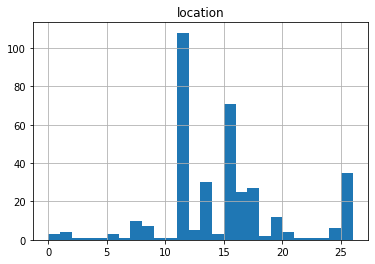

In [30]:
data = labelEncode(data, 'location')
data.hist(column='location', bins = 26)

In the histogram above it can be seen that there are more house sales in Cebu, followed by Lapu-Lapu, and Talisay.

### Removing multicollinearity

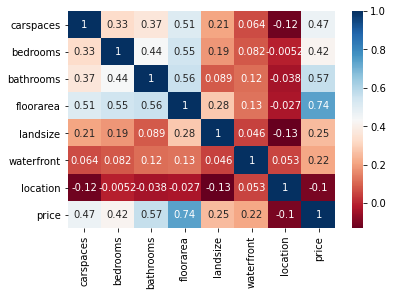

In [31]:
data = displayHeatMap(data)

In [32]:
displayVFI(data)

Current VFI


const         16.670943
carspaces      1.419796
bedrooms       1.491787
bathrooms      1.675646
floorarea      2.890105
landsize       1.130949
waterfront     1.059106
location       1.048262
price          2.572541
dtype: float64

In [33]:
displayDescribe(data)

,carspaces,bedrooms,bathrooms,floorarea,landsize,waterfront,location,price
count,364.000000,364.000000,364.000000,364.000000,364.000000,364.000000,364.000000,3.640000e+02
mean,1.944058,3.908689,3.498463,218.384537,334.932195,0.214286,14.326923,1.451708e+07
std,1.062035,1.880737,7.404907,221.151053,753.438095,0.410891,5.166670,2.026973e+07
min,0.000000,1.000000,1.000000,2.000000,35.000000,0.000000,0.000000,5.000000e+04
25%,1.000000,3.000000,2.000000,85.000000,91.500000,0.000000,11.000000,4.482500e+06
50%,1.931452,4.000000,3.000000,145.500000,156.000000,0.000000,15.000000,8.000000e+06
75%,2.000000,4.000000,4.000000,270.500000,307.000000,0.000000,16.000000,1.650800e+07
max,8.000000,18.000000,141.000000,2100.000000,10000.000000,1.000000,26.000000,2.000000e+08
+3_std,5.130162,9.550900,25.713184,881.837695,2595.246479,1.446958,29.826933,7.532627e+07
-3_std,-1.242046,-1.733522,-18.716257,-445.068620,-1925.382090,-1.018386,-1.173087,-4.629211e+07


In [34]:
data = removeOutliers(data)

Number of outliers found:  29


,carspaces,bedrooms,bathrooms,floorarea,landsize,waterfront,location,price
0,2.0,2.0,3.0,150.0,173.0,1.0,15.0,3800000.0
1,1.0,3.0,2.0,80.0,291.0,1.0,1.0,7078000.0
2,5.0,3.0,2.0,385.4,1500.0,1.0,7.0,11900000.0
3,4.0,5.0,5.0,360.0,462.0,0.0,15.0,52000000.0
4,1.0,4.0,3.0,103.0,60.0,0.0,17.0,10500000.0
...,...,...,...,...,...,...,...,...
396,1.0,1.0,1.0,26.0,48.0,0.0,3.0,619682.0
398,1.0,4.0,3.0,284.0,103.0,1.0,19.0,5242410.0
400,1.0,4.0,2.0,114.0,72.0,1.0,11.0,5500000.0
401,1.0,2.0,2.0,36.0,42.0,1.0,8.0,1350000.0


### Training Models

In [35]:
# instantiate models
modelLR = LinearRegression()
modelRF = RandomForestRegressor(max_depth=4)
modelDT = DecisionTreeRegressor(max_depth=4)

In [36]:
X = data.iloc[ : , 0:7]
Y = data.iloc[ : , 7]

X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.20, random_state=32)

In [37]:
modelLR.fit(X_train, Y_train)
modelRF.fit(X_train, Y_train)
modelDT.fit(X_train, Y_train)

DecisionTreeRegressor(max_depth=4)

In [38]:
getScore("Linear Regression Model", modelLR)
getScore("Random Forest Regression Model", modelRF)
getScore("Decision Tree Regressor" ,modelDT)

Linear Regression Model
Train R-Squared:  0.6533695776517655
Test R-Squared:  0.6974979756711742

Random Forest Regression Model
Train R-Squared:  0.8469193675666129
Test R-Squared:  0.8240857569789024

Decision Tree Regressor
Train R-Squared:  0.7898447458514584
Test R-Squared:  0.797062508351994



### Identifying Errors

In [39]:
LRpred = modelLR.predict(X_test)
RFpred = modelRF.predict(X_test)
DTpred = modelDT.predict(X_test) 

In [40]:
getErrors("Linear Regression Model", LRpred)
getErrors("Random Forest Regression Model", RFpred)
getErrors("Decision Tree Regressor", DTpred)

Linear Regression Model
Mean Squared Error (MSE):  49047984422100.36
Mean Absolute Error (MAE):  4356215.333848747
Root Mean Squared Error (RMSE):  7003426.620026825

Random Forest Regression Model
Mean Squared Error (MSE):  28522913426672.81
Mean Absolute Error (MAE):  3063032.340548233
Root Mean Squared Error (RMSE):  5340684.733877558

Decision Tree Regressor
Mean Squared Error (MSE):  32904490312407.54
Mean Absolute Error (MAE):  3335876.030847365
Root Mean Squared Error (RMSE):  5736243.571572562



## Linear Regression

#### Determine Intercept and Coefficients

In [41]:
getInterceptCoeff(modelLR)


 The intercept for our model is -4.848e+06


,Coefficients
carspaces,1.216281e+06
bedrooms,-3.624131e+05
bathrooms,3.170960e+06
floorarea,2.902430e+04
landsize,3.661332e+03
waterfront,1.507583e+06
location,-6.323934e+04


In [42]:
# define our input
X2 = sm.add_constant(X)

# create a OLS model
model = sm.OLS(Y, X2)

# fit the data
est = model.fit()

#### Test for Heterosecdasticity

In [43]:
checkHeterosecdasticity(est)

5.989089596073254e-15 4.3888766150610684e-17
----------------------------------------------------------------------------------------------------
For the Breusch-Pagan's Test
The p-value was 5.989e-15
We reject the null hypothesis, so there is heterosecdasticity.


#### Test for Autocorrelation

The number of lags will be 10
----------------------------------------------------------------------------------------------------
The lowest p-value found was 0.3167
We fail to reject the null hypothesis, so there is no autocorrelation.
----------------------------------------------------------------------------------------------------


c:\users\ginn\appdata\local\programs\python\python38\lib\site-packages\statsmodels\stats\diagnostic.py:559: FutureWarning: The value returned will change to a single DataFrame after 0.12 is released.  Set return_df to True to use to return a DataFrame now.  Set return_df to False to silence this warning.
  warnings.warn(msg, FutureWarning)


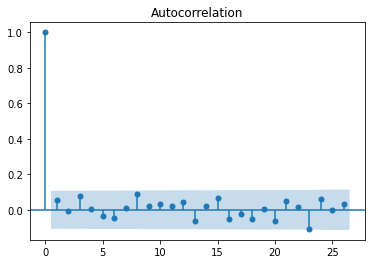

In [44]:
checkAutocorr(est, X)

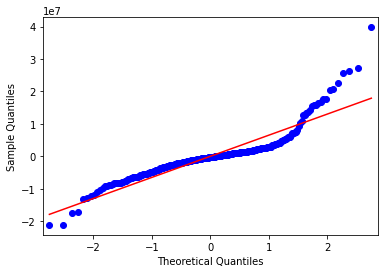

The mean of the residuals is 1.0818354229428875e-07


In [45]:
scatterPlot(est)

#### Prediction

In [46]:
getPredict(modelLR, X_test)

Price for the first 5 predictions: 
10035800.40122176
8680236.684682747
11831963.560287531
2475086.14980027
6999488.311756821


#### Summary

In [47]:
est.pvalues

const         1.812725e-02
carspaces     6.701225e-02
bedrooms      5.517810e-01
bathrooms     1.783837e-08
floorarea     2.261473e-18
landsize      3.141364e-02
waterfront    1.695132e-01
location      1.716978e-01
dtype: float64

In [48]:
# define our input
X2 = sm.add_constant(X)
X2 = X2.drop(['carspaces', 'bedrooms', 'waterfront', 'location'], axis = 1)

# create a OLS model
model = sm.OLS(Y, X2)

# fit the data
est = model.fit()

In [49]:
est.pvalues

const        1.772250e-06
bathrooms    1.308877e-11
floorarea    8.751757e-20
landsize     6.467499e-03
dtype: float64

In [50]:
print(est.summary())

                            OLS Regression Results                            
Dep. Variable:                  price   R-squared:                       0.663
Model:                            OLS   Adj. R-squared:                  0.660
Method:                 Least Squares   F-statistic:                     216.7
Date:                Thu, 25 Mar 2021   Prob (F-statistic):           9.44e-78
Time:                        08:32:46   Log-Likelihood:                -5734.9
No. Observations:                 335   AIC:                         1.148e+04
Df Residuals:                     331   BIC:                         1.149e+04
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const      -4.473e+06   9.19e+05     -4.865      0.0

## Decision Tree Model

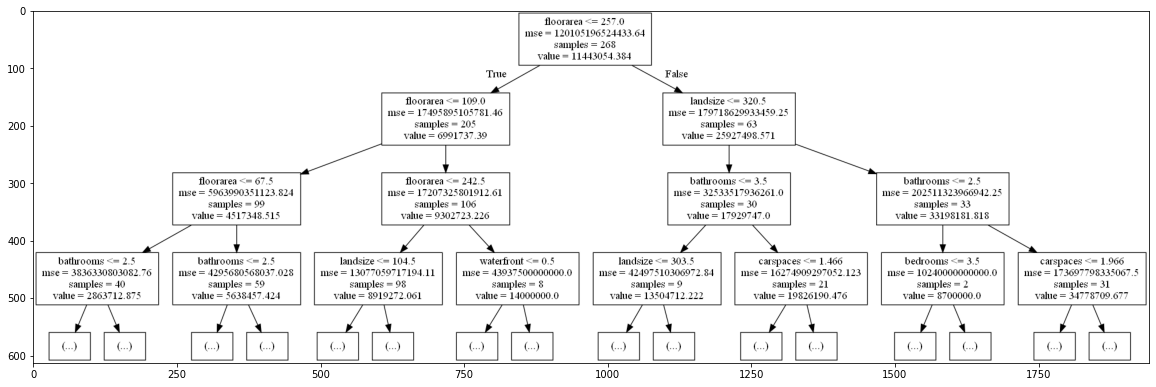

In [51]:
getDecisionTree(modelDT, data.iloc[0:0, 0:7])

#### Importance of Variables

In [52]:
print_important_variables(modelDT,data.iloc[0:0, 0:7])

,Variables,Importance
0,floorarea,0.74
1,landsize,0.16
2,bathrooms,0.06
3,carspaces,0.03
4,waterfront,0.01
5,bedrooms,0.00
6,location,0.00


## Random Forest Model

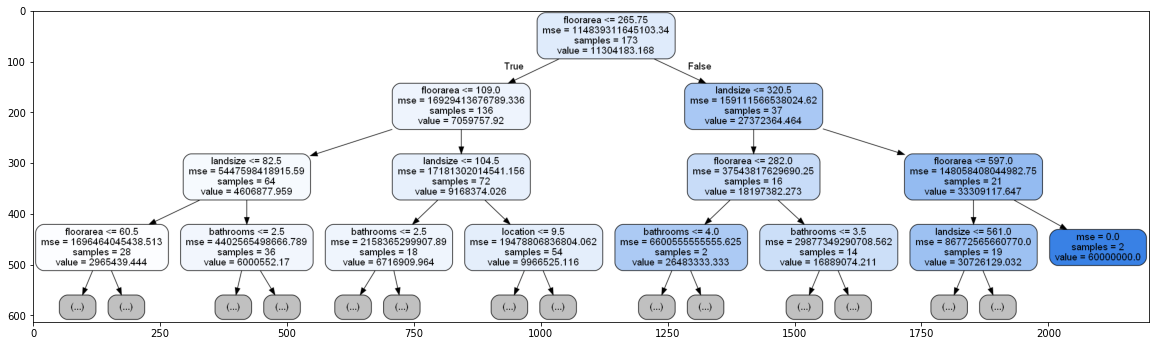

In [53]:
getRandomForestTree(modelRF, noOfTree = 1, depth = 3)

#### Importance of Variables

In [54]:
print_important_variables(modelRF,data.iloc[0:0, 0:7])

,Variables,Importance
0,floorarea,0.68
1,landsize,0.18
2,bathrooms,0.08
3,carspaces,0.03
4,bedrooms,0.02
5,location,0.02
6,waterfront,0.00


### Conclusion

In the accuracy of different models shown above, the Random Forest model with 84% and Decision Tree model with 79% are the models that has an acceptable score. Thus, Linear Regression Model will not be used because it has the accuracy of 65% only. And with the RMSE shown above the Linear Regression model has the highest with the value of 7 million, Decision Tree model with 5.7 million and Random Forest model has the lowest with 5.2 million 

**Linear Regression Equation:**

Price = -4,473,000 + 2,820,000 (bathrooms) + 35,860 (floorarea) + 4320.9739 (landsize)

Assuming a house for sale has 2 bathrooms, 51 sqm floor area, 98 sqm land size

In [55]:
Price = -4473000 + 2820000*2 + 35860*51 + 4320.9739*98
print(f'The house would be around Php {Price}')

The house would be around Php 3419315.4422


**Comparing of important variables**

|Variables||Linear Regression||Decision Tree||Random Forest|
|:-:||:-:||:-:||:-:|
|floorarea||/||/||/|
|landsize||/||/||/|
|bathrooms||/||/||/|
|carspaces||||/||/|
|bedrooms||||||/|
|waterfront||||/||/|

<br>

In the importantance of the variables, the floorarea, landsize, and bathrooms are the most common of the all variables and has high importance in where the researchers can now conclude that these variables are the most important when looking for a house for sale